In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = yf.download('AAPL', period='5y')
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2020-06-17,85.442421,86.368316,85.320912,86.307562,114406400
1,2020-06-18,85.476463,85.894453,84.866488,85.398696,96820400
2,2020-06-19,84.987999,86.650236,83.877408,86.183647,264476000
3,2020-06-22,87.211617,87.354996,85.335523,85.381697,135445200
4,2020-06-23,89.073112,90.494765,88.037857,88.458279,212155600


In [4]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

In [5]:
df.tail()

Price,Date,Close,High,Low,Open,Volume,SMA_10,EMA_10
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,
1252,2025-06-11,198.779999,204.500000,198.410004,203.500000,60989900,201.604001,201.627015
1253,2025-06-12,199.199997,199.679993,197.360001,199.080002,43904600,201.529001,201.185739
1254,2025-06-13,196.449997,200.369995,195.699997,199.729996,51447300,201.089000,200.324695
1255,2025-06-16,198.419998,198.690002,196.559998,197.300003,42886800,200.761000,199.978386
1256,2025-06-17,196.835007,197.929993,196.255005,197.199997,5453384,200.117500,199.406863


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1257 non-null   datetime64[ns]
 1   (Close, AAPL)   1257 non-null   float64       
 2   (High, AAPL)    1257 non-null   float64       
 3   (Low, AAPL)     1257 non-null   float64       
 4   (Open, AAPL)    1257 non-null   float64       
 5   (Volume, AAPL)  1257 non-null   int64         
 6   (SMA_10, )      1248 non-null   float64       
 7   (EMA_10, )      1257 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 78.7 KB


In [7]:
df.describe()

Price,Date,Close,High,Low,Open,Volume,SMA_10,EMA_10
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,
count,1257,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03,1248.000000,1257.000000
mean,2022-12-15 01:28:12.601432064,165.222937,166.920456,163.348528,165.072541,8.000200e+07,165.385703,164.814950
min,2020-06-17 00:00:00,84.987999,85.894453,83.877408,85.381697,5.453384e+06,87.086450,85.364863
25%,2021-09-15 00:00:00,138.301208,140.089304,136.136524,138.427235,5.223810e+07,139.432423,139.469758
50%,2022-12-13 00:00:00,163.157349,164.550109,161.243345,162.881630,6.990710e+07,163.034657,162.942924
75%,2024-03-15 00:00:00,188.986176,190.210443,187.596200,188.727393,9.462560e+07,188.806572,187.752587
max,2025-06-17 00:00:00,258.396667,259.474086,257.010028,257.568678,3.743368e+08,253.102451,252.768876
std,NaN,37.655770,37.838035,37.373534,37.572507,4.149193e+07,37.236370,37.616860


In [8]:
df.isnull().sum()

Price   Ticker
Date              0
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
SMA_10            9
EMA_10            0
dtype: int64

In [9]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

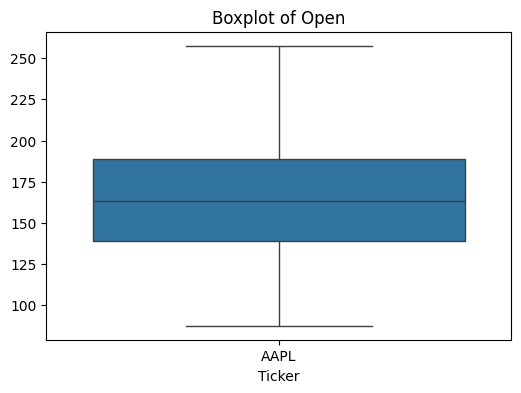

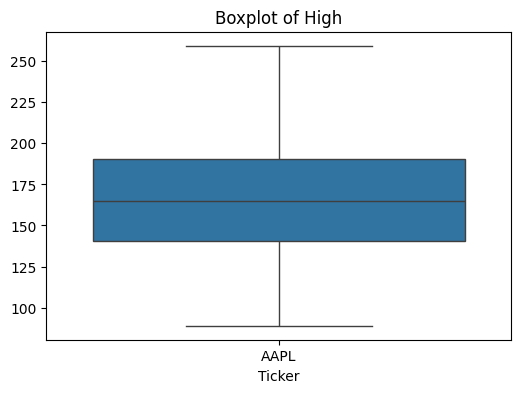

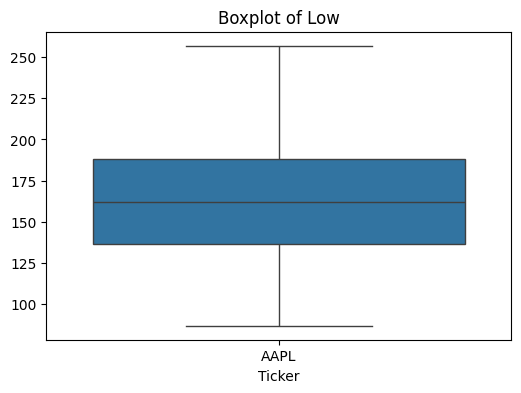

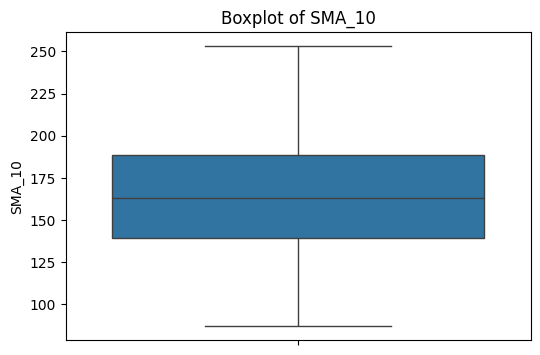

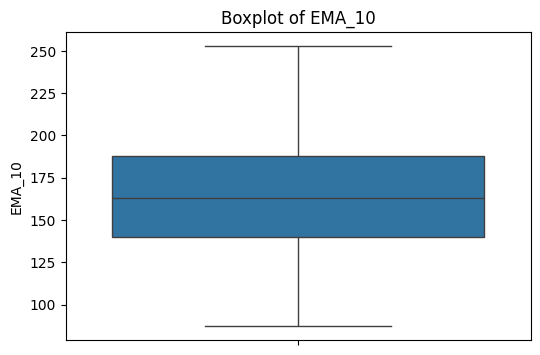

In [10]:
for col in ['Open', 'High', 'Low', 'SMA_10', 'EMA_10']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [11]:
features = df[['Open', 'High', 'Low', 'SMA_10', 'EMA_10']].values
target = df['Close'].values.reshape(-1,1)

In [12]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [13]:
features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target)

In [14]:
SEQ_LEN = 60

In [15]:
X = []
y = []

In [16]:
for i in range(SEQ_LEN, len(features_scaled)):
    X.append(features_scaled[i-SEQ_LEN:i])
    y.append(target_scaled[i])

In [17]:
X, y = np.array(X), np.array(y)

In [18]:
split = int(0.8 * len(X))

In [19]:
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [20]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(50))
model.add(Dense(1))

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)


In [23]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 0.0592 - val_loss: 0.0337
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0049 - val_loss: 0.0076
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 111

In [24]:
preds_scaled = model.predict(X_test)
preds = scaler_y.inverse_transform(preds_scaled)
actual = scaler_y.inverse_transform(y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


In [25]:
rmse = np.sqrt(mean_squared_error(actual, preds))
mae = mean_absolute_error(actual, preds)
r2 = r2_score(actual, preds)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Test RMSE: 4.9905
Test MAE: 3.7635
R² Score: 0.8955


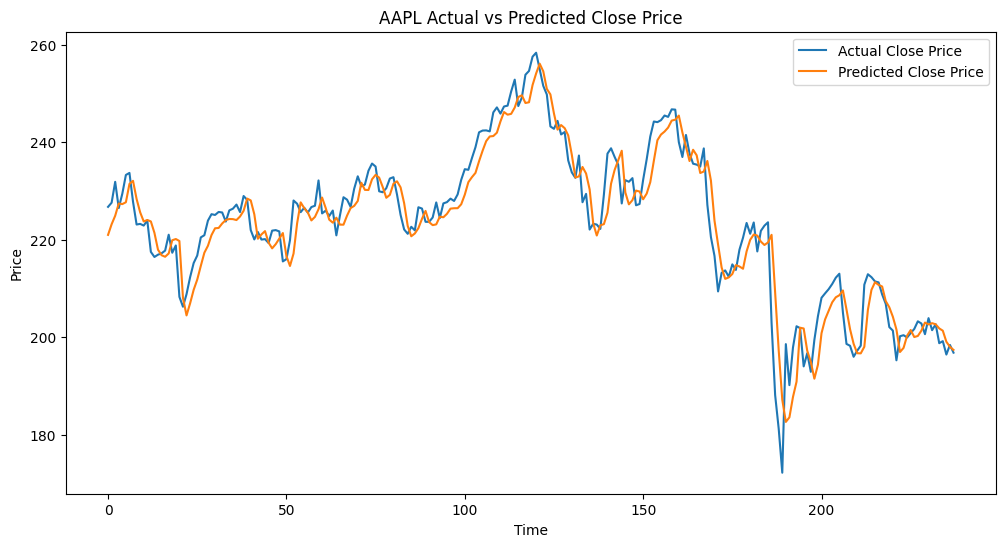

In [26]:
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual Close Price')
plt.plot(preds, label='Predicted Close Price')
plt.title("AAPL Actual vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

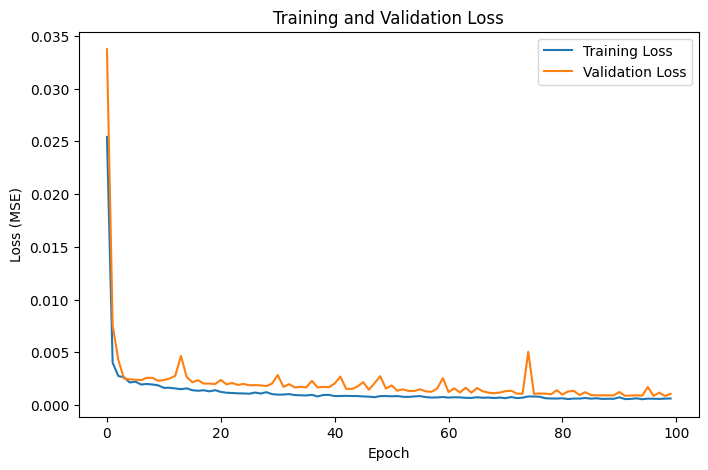

In [27]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [28]:
model.save("lstm_stock_model.h5")

In [29]:
class StockTradingEnv(gym.Env):
    def __init__(self, prices):
        super(StockTradingEnv, self).__init__()
        self.prices = prices
        self.n_step = len(prices)
        self.current_step = 0
        self.action_space = gym.spaces.Discrete(3)  # Hold, Buy, Sell
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)  # Open, High, Low scaled
        self.position = 0  # 0: no stock, 1: holding stock
        self.buy_price = 0
        self.total_profit = 0

    def reset(self):
        self.current_step = 0
        self.position = 0
        self.buy_price = 0
        self.total_profit = 0
        return self._next_observation()

    def _next_observation(self):
        return self.prices[self.current_step][:3]

    def step(self, action):
        reward = 0
        done = False

        current_price = self.prices[self.current_step][0]  # Open price as current price

        if action == 1:  # Buy
            if self.position == 0:
                self.position = 1
                self.buy_price = current_price
        elif action == 2:  # Sell
            if self.position == 1:
                profit = current_price - self.buy_price
                reward = profit
                self.total_profit += profit
                self.position = 0
                self.buy_price = 0
        else:  # Hold
            reward = 0

        self.current_step += 1
        if self.current_step >= self.n_step - 1:
            done = True

            obs = np.zeros(self.observation_space.shape, dtype=np.float32)
        else:
            obs = self._next_observation()
        return obs, reward, done, {}

In [30]:
prices_for_rl = X_test[:, -1, :]

In [31]:
env = DummyVecEnv([lambda: StockTradingEnv(prices_for_rl)])

In [32]:
rl_model = PPO("MlpPolicy", env, verbose=1)
rl_model.learn(total_timesteps=10000)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 640  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 414         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012169599 |
|    clip_fraction        | 0.0772      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.413       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0176      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.003      |
|    value_loss           | 0.00427     |
-----------------------------------------
-----------------

In [33]:
rl_model.save('ppo_stock_trading')

In [34]:
import joblib
joblib.dump(scaler_x, "scaler_x.pkl")

['scaler_x.pkl']